In [1]:
import numpy as np
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import os
import shutil

In [2]:
labelMap = {
    0 : 'Cool',
    1 : 'Hateful'
}

In [3]:
def plotImage(img):
    if type(img) == dict or type(img) == pd.Series:
        label = img['label']
        print("Label: ", label, labelMap[label])
        img = img['img']
    if type(img) == str:
        print("Filename: ", img)
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

In [4]:
def importDataset(base, filename):
    f = open(base+'/annotations/'+filename, 'r').read().split('\n')
    data = []
    for i in f:
        d = json.loads(i)
        d['img'] = base + '/images/' + d['img']
        data.append(d)
    return pd.DataFrame(data)

def loadPredictions(filename):
    data = pd.read_csv(filename)
    return data

In [5]:
devSet = importDataset('mmfCache/data/datasets/hateful_memes/defaults', 'dev.jsonl')

In [6]:
trainSet = importDataset('mmfCache/data/datasets/hateful_memes/defaults', 'train.jsonl')

In [7]:
testSet = importDataset('mmfCache/data/datasets/hateful_memes/defaults', 'test.jsonl')

In [8]:
devSet.iloc[0], len(devSet)

(id                                                    8291
 img      mmfCache/data/datasets/hateful_memes/defaults/...
 label                                                    1
 text                 white people is this a shooting range
 Name: 0, dtype: object,
 500)

In [9]:
len(devSet), len(trainSet)

(500, 8500)

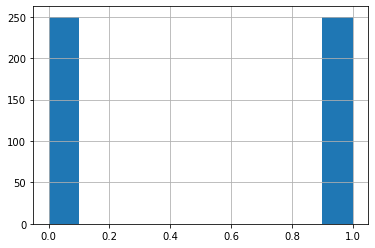

In [10]:
devSet['label'].hist()

Label:  0 Cool
Filename:  mmfCache/data/datasets/hateful_memes/defaults/images/img/01742.png


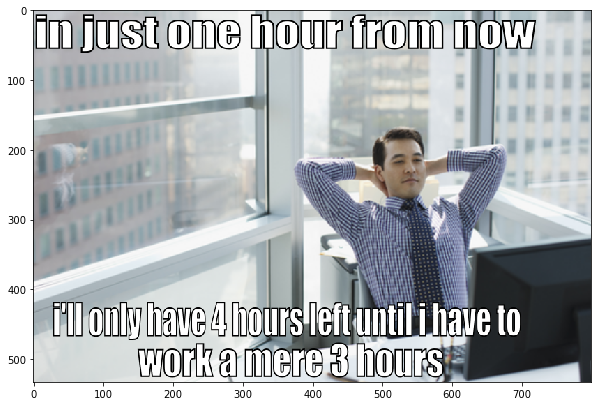

In [11]:
plotImage(devSet.iloc[220])

In [31]:
# For dev sets -->
# visualbertPreds = loadPredictions('save/hateful_memes_visual_bert_33632377/reports/hateful_memes_run_val_2020-07-28T13:39:53.csv')
visualbertPreds = loadPredictions('/ssd/HateFullMemes/save/hateful_memes_visual_bert_29297509/reports/hateful_memes_run_val_2020-08-09T12:09:49.csv')

# vilbert -->
# visualbertPreds = loadPredictions('/ssd/HateFullMemes/save/hateful_memes_late_fusion_23978336/reports/hateful_memes_run_val_2020-08-09T17:01:44.csv')

In [11]:
# For training sets -->
visualbertPreds = loadPredictions('/ssd/HateFullMemes/save/hateful_memes_visual_bert_45619731/reports/hateful_memes_run_val_2020-08-09T12:00:34.csv')

# vilbert -->

In [251]:
# For test set -->
visualbertPreds = loadPredictions('/ssd/HateFullMemes/save/hateful_memes_visual_bert_47210005/reports/hateful_memes_run_test_2020-08-09T17:48:34.csv')

In [148]:
len(visualbertPreds)

500

In [23]:
visualbertPreds.head()

,id,proba,label
0,8291,0.741540,1
1,46971,0.105018,0
2,3745,0.001221,0
3,83745,0.808150,1
4,80243,0.982800,1


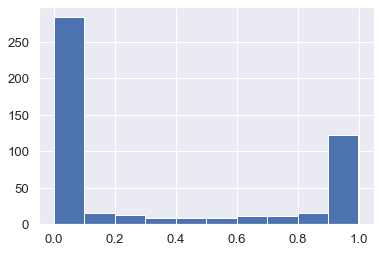

In [32]:
visualbertPreds['proba'].hist()

In [15]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [16]:
def plotConfusion(confusion):
    df_cm = pd.DataFrame(confusion, range(2), range(2), dtype=np.int)
    sn.set(font_scale=1.2) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size
    plt.show()
    
def evaluate(data, preds, conf=0.5):
    truePos = []
    trueNegs = []
    falsePos = []
    falseNegs = []
    for i, row in data.iterrows():
        pred = preds[preds['id'] == row['id']].iloc[0]
        if row['label'] == 1:
            # positive
            if pred['proba'] <= conf:
                # False Negative
                falseNegs.append({'id':row['id'], 'type':'fn', 'pred':pred['label'], 'act':row['label'], 'conf':pred['proba'], 'img':row['img'], 'text':row['text']})
            else:
                # True Positive
                truePos.append({'id':row['id'], 'type':'tp', 'pred':pred['label'], 'act':row['label'], 'conf':pred['proba'], 'img':row['img'], 'text':row['text']})
        else:
            # Negative
            if pred['proba'] <= conf:
                # True Negative
                trueNegs.append({'id':row['id'], 'type':'tn', 'pred':pred['label'], 'act':row['label'], 'conf':pred['proba'], 'img':row['img'], 'text':row['text']})
            else:
                # False Positive
                falsePos.append({'id':row['id'], 'type':'fp', 'pred':pred['label'], 'act':row['label'], 'conf':pred['proba'], 'img':row['img'], 'text':row['text']})
    confusion = [[len(trueNegs), len(falsePos)], [len(falseNegs), len(truePos)]]
    precision = len(truePos) / (len(truePos) + len(falsePos))
    recall = len(truePos) / (len(truePos) + len(falseNegs))
    f1score = (2 * (precision * recall)) / (precision + recall)
    accuracy = (len(truePos) + len(trueNegs)) / len(data)
    return {
        'raw':[pd.DataFrame(i) for i in [truePos, falsePos, trueNegs, falseNegs]],
        'confusion':confusion, 
        'pr': (precision, recall),
        'f1': f1score,
        'accuracy' : accuracy,
    }

def genPR(data, preds, minConf=0.01, res=50):
    pr = []
    for i in np.linspace(minConf, 1.0, res):
        try:
            results = evaluate(devSet, visualbertPreds, conf=i)
            print("Confidence :", i, "\n\t\tPrecision: ", results['pr'], "\tF1 Score:" , results['f1'], "\tAccuracy: ", results['accuracy'])
            plotConfusion(results['confusion'])
            pr.append(results['pr'])
        except Exception as e:
            print("Confidence :", i, "Precision: ", [1, 0])
            pr.append([1, 0])
    return pr

def genROC(data, preds, minConf=0.01, res=50):
    rocs = []
    for i in np.linspace(minConf, 1.0, res):
        try:
            results = evaluate(devSet, visualbertPreds, conf=i)
            print("Confidence :", i, "\n\t\tPrecision: ", results['pr'], "\tF1 Score:" , results['f1'], "\tAccuracy: ", results['accuracy'])
            plotConfusion(results['confusion'])
            tp = results['confusion'][1][1]
            fn = results['confusion'][1][0]
            tpr = tp / (tp + fn)
            fp = results['confusion'][0][1]
            tn = results['confusion'][0][0]
            fpr = fp / (fp + tn)
            rocs.append([tpr, fpr])
        except Exception as e:
            print("Confidence :", i, "Precision: ", [1, 0])
            rocs.append([0, 0])
    return rocs

def plotPR(pr, scatter=True, display=True, endpoint=True):
    x = [i[0] for i in pr] # Precision
    y = [i[1] for i in pr] # Recall
    if endpoint:
        plt.ylim([0.0, 1.00])
        plt.xlim([0.0, 1.0])
    plt.plot(y, x)
    if scatter:
        plt.scatter(y, x)
    if display:
        plt.show()

In [17]:
def dataSaver(dataset, base='', relabel=True):
    if os.path.exists(base) is False:
        os.mkdir(base)
    for iterr, row in dataset.iterrows():
        image = cv2.imread(row['img'])
        filename = ('.'.join((row['img'].split('/')[-1]).split('.')[:-1]))
        if relabel:
            conf = row['conf']
            act = row['act']
    #         print(filename)
            filename += '_act-' + str(act) + '_conf-' + str(conf).replace('.','_') + '.jpg' 
        else:
            filename += '.jpg'
        cv2.imwrite(base + '/' + filename, image)
        
    
def saveProcessesed(rawResults, location='./ErrorAnalysisOnVal/DefaultConf0.5/'):
    if os.path.exists(location) is False:
        os.mkdir(location)
    truePos, falsePos, trueNegs, falseNegs = rawResults
    dataSaver(truePos, location + '/TruePositives/')
    dataSaver(falsePos, location + '/FalsePositives/')
    dataSaver(falseNegs, location + '/FalseNegatives/')
    dataSaver(trueNegs, location + '/TrueNegatives/')

Precision:  (0.6941176470588235, 0.472) 	F1 Score: 0.5619047619047619 	Accuracy:  0.632


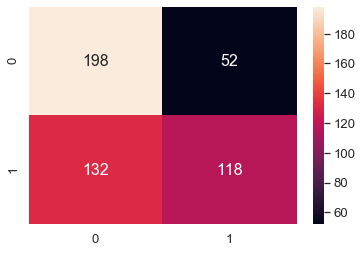

In [18]:
results = evaluate(devSet, visualbertPreds)
print("Precision: ", results['pr'], "\tF1 Score:" , results['f1'], "\tAccuracy: ", results['accuracy'])
plotConfusion(results['confusion'])
truePos, falsePos, trueNegs, falseNegs = results['raw']
# saveProcessesed(results['raw'], location='./ErrorAnalysisOnVal/visual_bert_coco/DefaultConf0.5/')

Precision:  (0.6877470355731226, 0.696) 	F1 Score: 0.6918489065606361 	Accuracy:  0.69


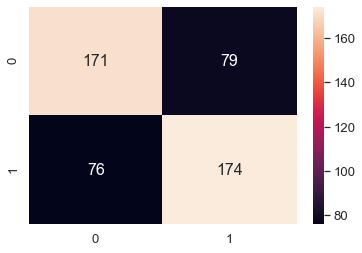

In [19]:
results = evaluate(devSet, visualbertPreds, 0.04)
print("Precision: ", results['pr'], "\tF1 Score:" , results['f1'], "\tAccuracy: ", results['accuracy'])
plotConfusion(results['confusion'])
truePos, falsePos, trueNegs, falseNegs = results['raw']
# saveProcessesed(results['raw'], location='./ErrorAnalysisOnVal/visual_bert_coco/BestConf0.04/')

In [63]:
len(falsePos)

79

In [64]:
peoples = ['ashish', 'digvijay', 'anisha', 'suhuruth', 'sourav']

In [131]:
def splitDataForEveryone(data, peoples, degree=2):
    dataSplit = {}
    for p in peoples:
        dataSplit[p] = []
    for i, row in data.iterrows():
        # Sample 'degree' random people
        peeps = np.random.choice(peoples, degree)
        # This datapoint would be assigned to peeps
        for p in peeps:
            dataSplit[p].append(row)
    for s in dataSplit:
        dataSplit[s] = pd.DataFrame(dataSplit[s])
    return dataSplit

def filterData(data, tags):
    for t in tags:
        if t not in data.columns:
            data[t] = [0] * len(data)
    return data[tags]

def saveSplits(split, type='falsePositive', delete=False, tags=[], location='./ErrorAnalysisOnVal/visual_bert_coco/ErrorSplits/', relabel=True, saveImage=True):
    for i in split:
        floc = location + i
        if delete:
            if os.path.exists(floc):
                shutil.rmtree(floc)
        if os.path.exists(floc) is False:
            os.mkdir(floc)
        data = filterData(split[i], tags)
        data.to_excel(floc + '/' + type + '_excel.xlsx')
        floc += '/' + type + '/'
        if os.path.exists(floc):
            shutil.rmtree(floc)
        os.mkdir(floc)
        if saveImage:
            dataSaver(split[i], floc, relabel)

In [106]:
splitsFP = splitDataForEveryone(falsePos, peoples, 2)
for i in splitsFP:
    print(i, "=>", len(splitsFP[i]))

ashish => 32
digvijay => 30
anisha => 29
suhuruth => 33
sourav => 34


In [78]:
#saveSplits(splitsFP, 'falsePositive', True)

In [91]:
splitsFN = splitDataForEveryone(falseNegs, peoples, 2)
for i in splitsFN:
    print(i, "=>", len(splitsFN[i]))

ashish => 28
digvijay => 30
anisha => 29
suhuruth => 31
sourav => 34


In [126]:
splits = {}
for i in splitsFP:
    splits[i] = pd.concat([splitsFP[i], splitsFN[i]])
    splits[i] = splits[i].sample(len(splits[i])).reset_index()

In [113]:
len(splits['ashish'])

60

In [132]:
saveSplits(splits, 'data', True, tags=['id', 'text', 'Hateful', 'Benign Confounder', 'Benign Text or Image', 'Comments'], 
          location='./ErrorAnalysisOnVal/visual_bert_coco/ErrorSplits/', relabel=False, saveImage=True)

In [133]:
saveSplits(splits, 'data', True, tags=['id', 'type', 'pred', 'act', 'conf', 'img', 'text', 'Hateful', 'Benign Confounder', 'Benign Text or Image', 'Comments'], 
          location='./ErrorAnalysisOnVal/visual_bert_coco/Orig/', relabel=False, saveImage=False)

In [82]:
splitsFP['ashish'].head()

,id,type,pred,act,conf,img,text
0,5349,fp,1.0,0,0.883548,mmfCache/data/datasets/hateful_memes/defaults/...,normal day in a islamic country
1,91405,fp,0.0,0,0.447572,mmfCache/data/datasets/hateful_memes/defaults/...,wears rag on her head so her brother husband d...
2,83497,fp,0.0,0,0.272475,mmfCache/data/datasets/hateful_memes/defaults/...,different types of radicalization
4,95038,fp,0.0,0,0.094456,mmfCache/data/datasets/hateful_memes/defaults/...,when you take these pics we think about cummin...
6,45062,fp,1.0,0,0.822503,mmfCache/data/datasets/hateful_memes/defaults/...,me and my kids are going to rob this country b...


In [20]:
import sklearn
from sklearn.metrics import *

Confidence : 0.01 
		Precision:  (0.5305676855895196, 0.972) 	F1 Score: 0.6864406779661016 	Accuracy:  0.556


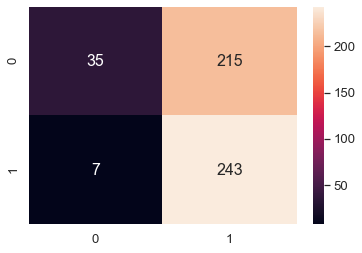

Confidence : 0.030204081632653063 
		Precision:  (0.6136986301369863, 0.896) 	F1 Score: 0.7284552845528455 	Accuracy:  0.666


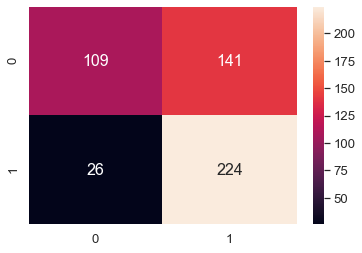

Confidence : 0.05040816326530612 
		Precision:  (0.6279761904761905, 0.844) 	F1 Score: 0.720136518771331 	Accuracy:  0.672


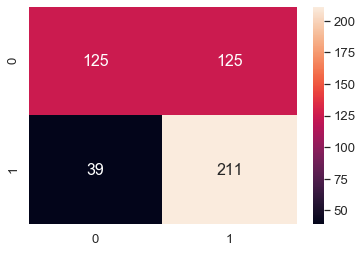

Confidence : 0.07061224489795918 
		Precision:  (0.6299694189602446, 0.824) 	F1 Score: 0.7140381282495666 	Accuracy:  0.67


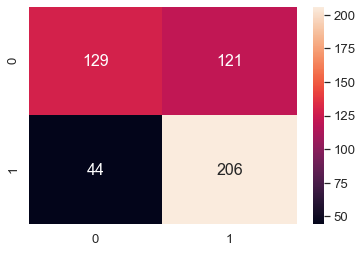

Confidence : 0.09081632653061224 
		Precision:  (0.632398753894081, 0.812) 	F1 Score: 0.711033274956217 	Accuracy:  0.67


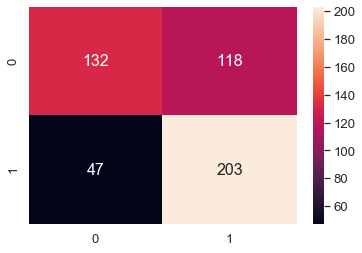

Confidence : 0.11102040816326529 
		Precision:  (0.637223974763407, 0.808) 	F1 Score: 0.7125220458553791 	Accuracy:  0.674


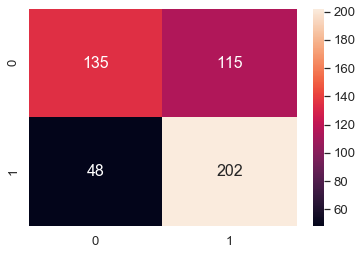

Confidence : 0.13122448979591836 
		Precision:  (0.639871382636656, 0.796) 	F1 Score: 0.7094474153297683 	Accuracy:  0.674


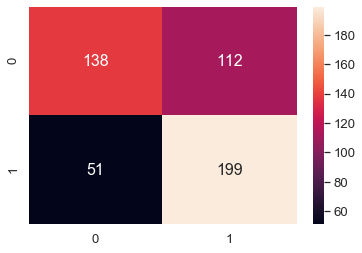

Confidence : 0.15142857142857144 
		Precision:  (0.6407766990291263, 0.792) 	F1 Score: 0.708407871198569 	Accuracy:  0.674


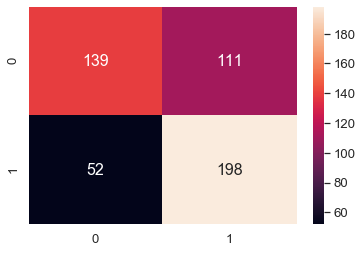

Confidence : 0.1716326530612245 
		Precision:  (0.6416938110749185, 0.788) 	F1 Score: 0.7073608617594255 	Accuracy:  0.674


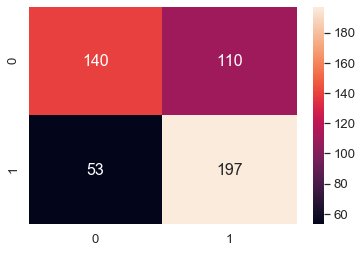

Confidence : 0.19183673469387755 
		Precision:  (0.6414473684210527, 0.78) 	F1 Score: 0.703971119133574 	Accuracy:  0.672


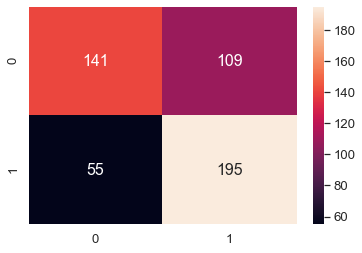

Confidence : 0.2120408163265306 
		Precision:  (0.6378737541528239, 0.768) 	F1 Score: 0.6969147005444646 	Accuracy:  0.666


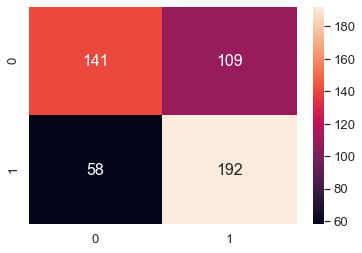

Confidence : 0.23224489795918368 
		Precision:  (0.6428571428571429, 0.756) 	F1 Score: 0.6948529411764706 	Accuracy:  0.668


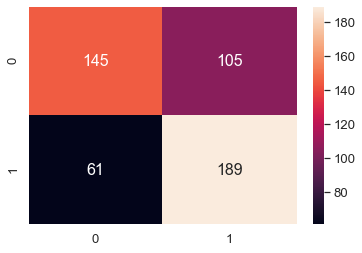

Confidence : 0.2524489795918367 
		Precision:  (0.6438356164383562, 0.752) 	F1 Score: 0.6937269372693727 	Accuracy:  0.668


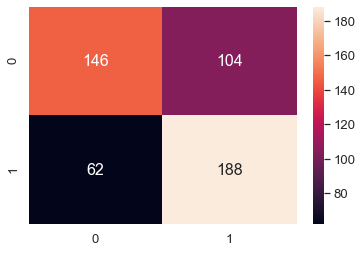

Confidence : 0.2726530612244898 
		Precision:  (0.6448275862068965, 0.748) 	F1 Score: 0.6925925925925926 	Accuracy:  0.668


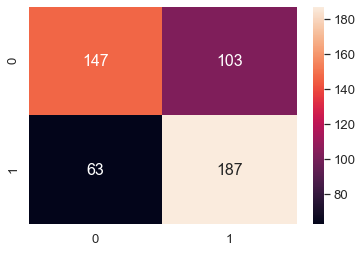

Confidence : 0.29285714285714287 
		Precision:  (0.6503496503496503, 0.744) 	F1 Score: 0.6940298507462687 	Accuracy:  0.672


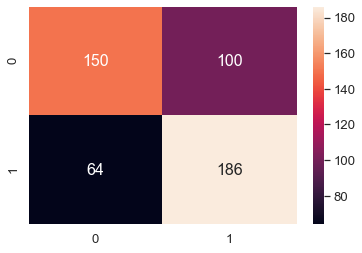

Confidence : 0.3130612244897959 
		Precision:  (0.6526315789473685, 0.744) 	F1 Score: 0.6953271028037383 	Accuracy:  0.674


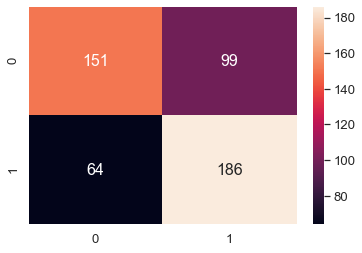

Confidence : 0.333265306122449 
		Precision:  (0.6514084507042254, 0.74) 	F1 Score: 0.6928838951310863 	Accuracy:  0.672


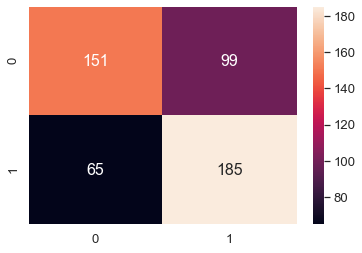

Confidence : 0.35346938775510206 
		Precision:  (0.6524822695035462, 0.736) 	F1 Score: 0.6917293233082706 	Accuracy:  0.672


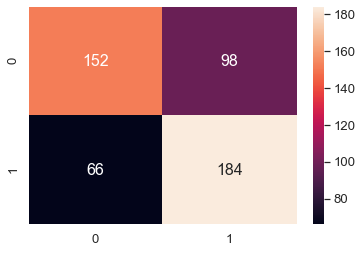

Confidence : 0.3736734693877551 
		Precision:  (0.6548042704626335, 0.736) 	F1 Score: 0.6930320150659134 	Accuracy:  0.674


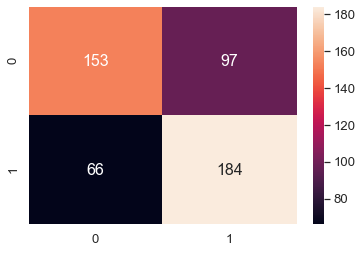

Confidence : 0.39387755102040817 
		Precision:  (0.6594982078853047, 0.736) 	F1 Score: 0.6956521739130435 	Accuracy:  0.678


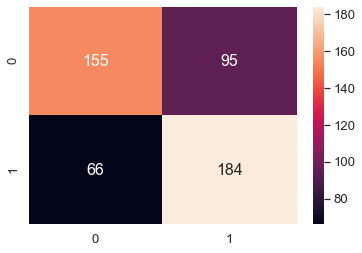

Confidence : 0.4140816326530612 
		Precision:  (0.6570397111913358, 0.728) 	F1 Score: 0.6907020872865275 	Accuracy:  0.674


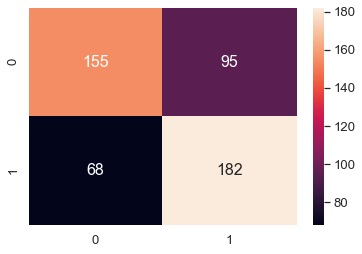

Confidence : 0.4342857142857143 
		Precision:  (0.6594202898550725, 0.728) 	F1 Score: 0.6920152091254753 	Accuracy:  0.676


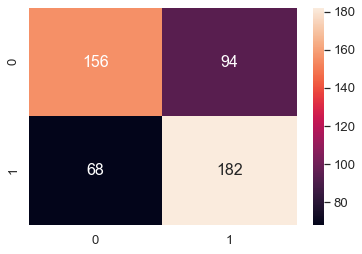

Confidence : 0.45448979591836736 
		Precision:  (0.6605839416058394, 0.724) 	F1 Score: 0.6908396946564885 	Accuracy:  0.676


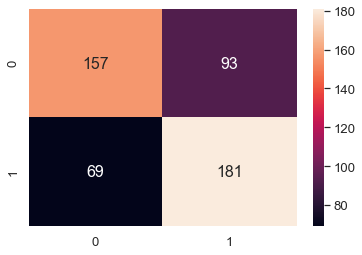

Confidence : 0.4746938775510204 
		Precision:  (0.6605839416058394, 0.724) 	F1 Score: 0.6908396946564885 	Accuracy:  0.676


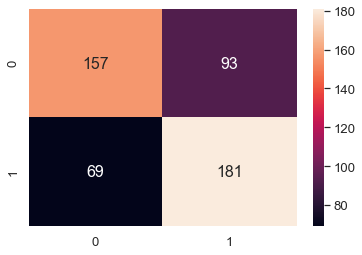

Confidence : 0.49489795918367346 
		Precision:  (0.6678966789667896, 0.724) 	F1 Score: 0.6948176583493282 	Accuracy:  0.682


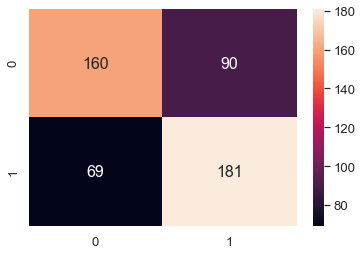

Confidence : 0.5151020408163265 
		Precision:  (0.6693548387096774, 0.664) 	F1 Score: 0.6666666666666667 	Accuracy:  0.668


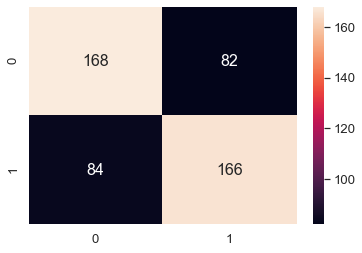

Confidence : 0.5353061224489796 
		Precision:  (0.6740088105726872, 0.612) 	F1 Score: 0.6415094339622641 	Accuracy:  0.658


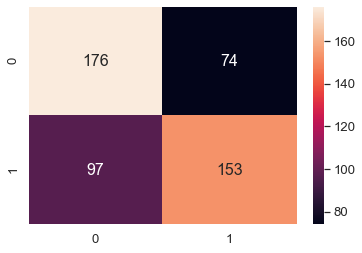

Confidence : 0.5555102040816327 
		Precision:  (0.6820276497695853, 0.592) 	F1 Score: 0.6338329764453962 	Accuracy:  0.658


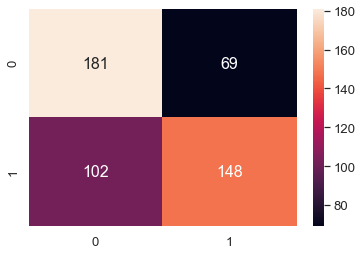

Confidence : 0.5757142857142857 
		Precision:  (0.6807511737089202, 0.58) 	F1 Score: 0.6263498920086393 	Accuracy:  0.654


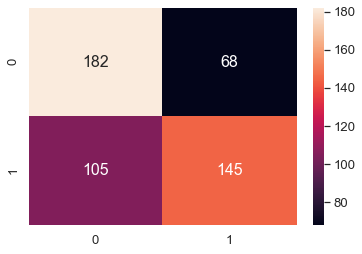

Confidence : 0.5959183673469388 
		Precision:  (0.6811594202898551, 0.564) 	F1 Score: 0.6170678336980306 	Accuracy:  0.65


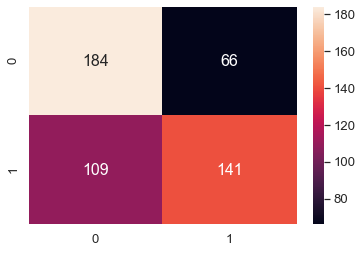

Confidence : 0.6161224489795918 
		Precision:  (0.6732673267326733, 0.544) 	F1 Score: 0.6017699115044247 	Accuracy:  0.64


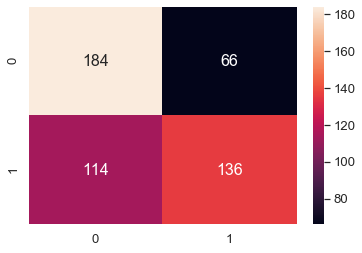

Confidence : 0.6363265306122449 
		Precision:  (0.673469387755102, 0.528) 	F1 Score: 0.5919282511210762 	Accuracy:  0.636


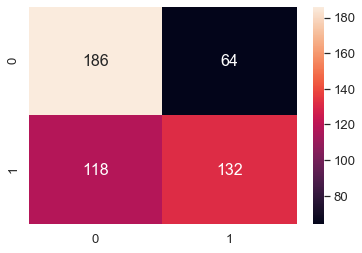

Confidence : 0.656530612244898 
		Precision:  (0.6770833333333334, 0.52) 	F1 Score: 0.588235294117647 	Accuracy:  0.636


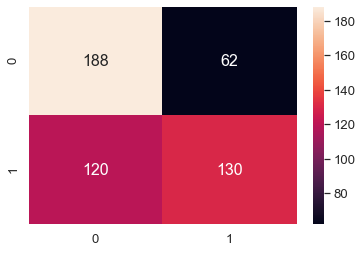

Confidence : 0.676734693877551 
		Precision:  (0.6825396825396826, 0.516) 	F1 Score: 0.5876993166287017 	Accuracy:  0.638


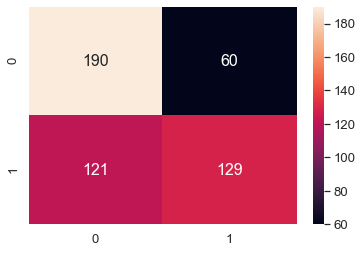

Confidence : 0.6969387755102041 
		Precision:  (0.6961325966850829, 0.504) 	F1 Score: 0.5846867749419953 	Accuracy:  0.642


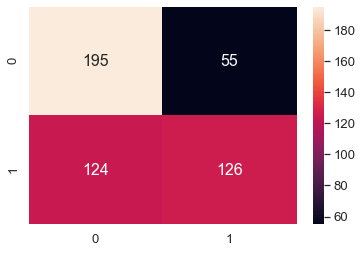

Confidence : 0.7171428571428571 
		Precision:  (0.6949152542372882, 0.492) 	F1 Score: 0.576112412177986 	Accuracy:  0.638


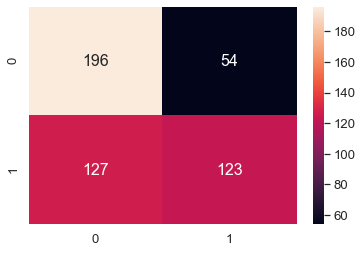

Confidence : 0.7373469387755102 
		Precision:  (0.6896551724137931, 0.48) 	F1 Score: 0.5660377358490566 	Accuracy:  0.632


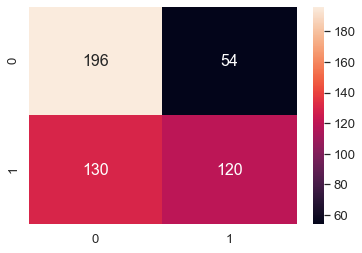

Confidence : 0.7575510204081632 
		Precision:  (0.6918604651162791, 0.476) 	F1 Score: 0.5639810426540285 	Accuracy:  0.632


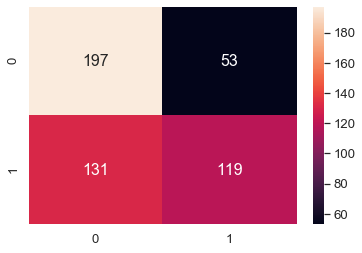

Confidence : 0.7777551020408163 
		Precision:  (0.6982248520710059, 0.472) 	F1 Score: 0.5632458233890215 	Accuracy:  0.634


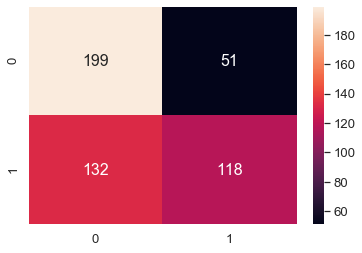

Confidence : 0.7979591836734694 
		Precision:  (0.7073170731707317, 0.464) 	F1 Score: 0.5603864734299517 	Accuracy:  0.636


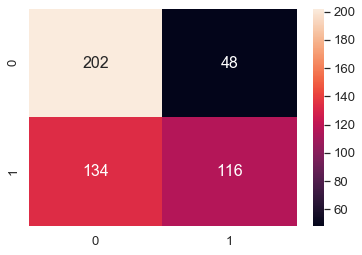

Confidence : 0.8181632653061224 
		Precision:  (0.71875, 0.46) 	F1 Score: 0.5609756097560976 	Accuracy:  0.64


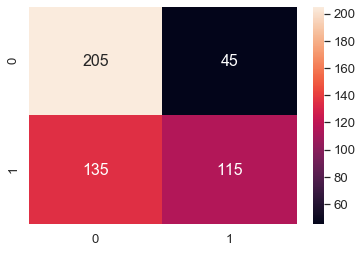

Confidence : 0.8383673469387755 
		Precision:  (0.7272727272727273, 0.448) 	F1 Score: 0.5544554455445545 	Accuracy:  0.64


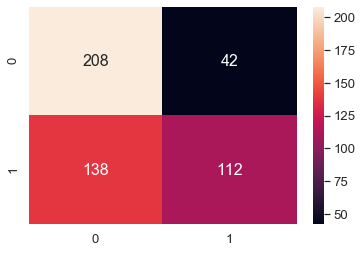

Confidence : 0.8585714285714285 
		Precision:  (0.7278911564625851, 0.428) 	F1 Score: 0.5390428211586902 	Accuracy:  0.634


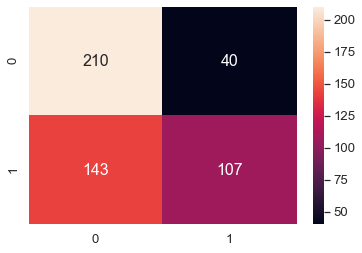

Confidence : 0.8787755102040816 
		Precision:  (0.7285714285714285, 0.408) 	F1 Score: 0.523076923076923 	Accuracy:  0.628


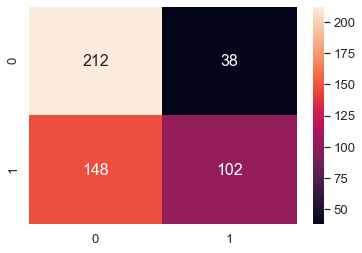

Confidence : 0.8989795918367347 
		Precision:  (0.7266187050359713, 0.404) 	F1 Score: 0.519280205655527 	Accuracy:  0.626


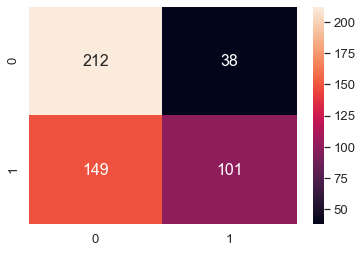

Confidence : 0.9191836734693878 
		Precision:  (0.7238805970149254, 0.388) 	F1 Score: 0.5052083333333334 	Accuracy:  0.62


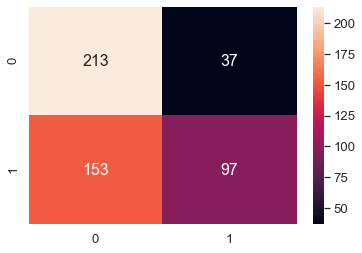

Confidence : 0.9393877551020408 
		Precision:  (0.717741935483871, 0.356) 	F1 Score: 0.4759358288770054 	Accuracy:  0.608


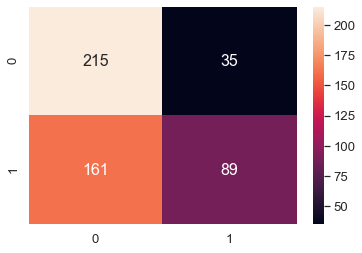

Confidence : 0.9595918367346938 
		Precision:  (0.7288135593220338, 0.344) 	F1 Score: 0.46739130434782605 	Accuracy:  0.608


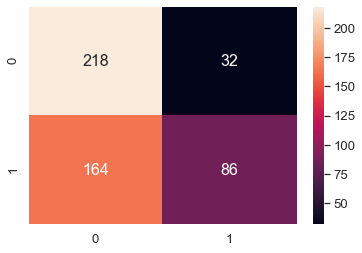

Confidence : 0.9797959183673469 
		Precision:  (0.74, 0.296) 	F1 Score: 0.4228571428571428 	Accuracy:  0.596


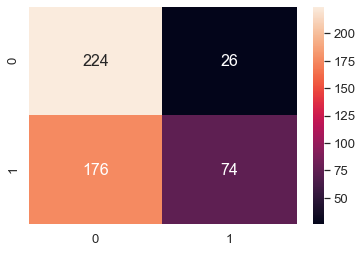

Confidence : 1.0 Precision:  [1, 0]


In [249]:
pr = genPR(devSet, visualbertPreds, 0.01, 50)

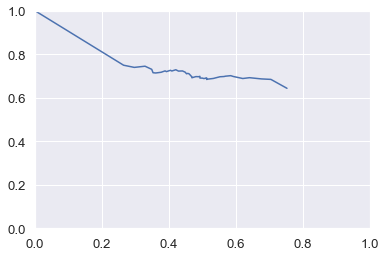

In [211]:
plotPR(pr, False)

In [242]:
p = [i[0] for i in pr]
r = [i[1] for i in pr]
auc = sklearn.metrics.auc(r, p)
auc

0.5749631035309886

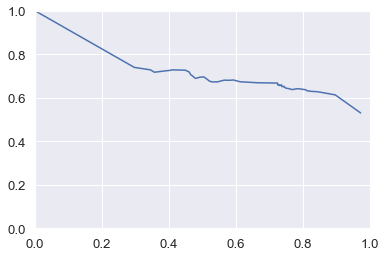

In [214]:
plotPR(pr, False)

In [250]:
p = [i[0] for i in pr]
r = [i[1] for i in pr]
auc = sklearn.metrics.auc(r, p)
auc

0.7084871326768994

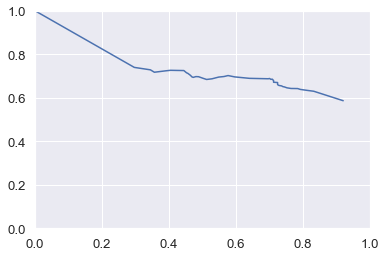

In [207]:
plotPR(pr, False)

In [246]:
p = [i[0] for i in pr]
r = [i[1] for i in pr]
auc = sklearn.metrics.auc(r, p)
auc

0.6821009355407068

Confidence : 0.01 
		Precision:  (0.5867346938775511, 0.92) 	F1 Score: 0.7165109034267912 	Accuracy:  0.636


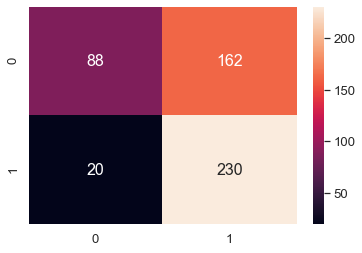

Confidence : 0.030204081632653063 
		Precision:  (0.6303030303030303, 0.832) 	F1 Score: 0.7172413793103447 	Accuracy:  0.672


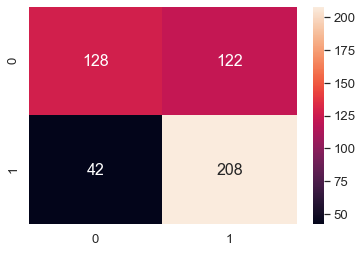

Confidence : 0.05040816326530612 
		Precision:  (0.634375, 0.812) 	F1 Score: 0.712280701754386 	Accuracy:  0.672


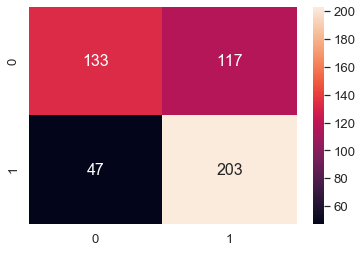

Confidence : 0.07061224489795918 
		Precision:  (0.6387096774193548, 0.792) 	F1 Score: 0.7071428571428572 	Accuracy:  0.672


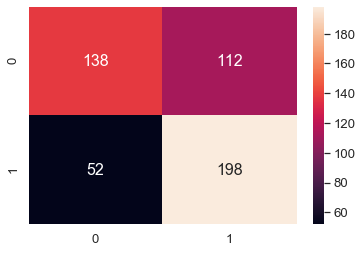

Confidence : 0.09081632653061224 
		Precision:  (0.6426229508196721, 0.784) 	F1 Score: 0.7063063063063063 	Accuracy:  0.674


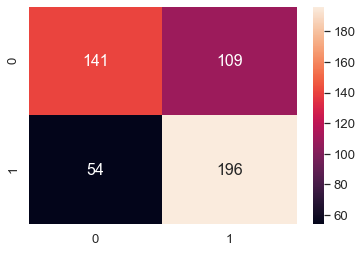

Confidence : 0.11102040816326529 
		Precision:  (0.6430976430976431, 0.764) 	F1 Score: 0.6983546617915904 	Accuracy:  0.67


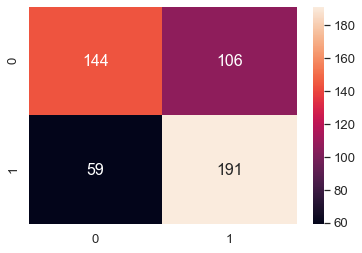

Confidence : 0.13122448979591836 
		Precision:  (0.6460481099656358, 0.752) 	F1 Score: 0.6950092421441775 	Accuracy:  0.67


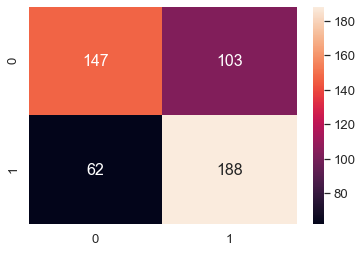

Confidence : 0.15142857142857144 
		Precision:  (0.6503496503496503, 0.744) 	F1 Score: 0.6940298507462687 	Accuracy:  0.672


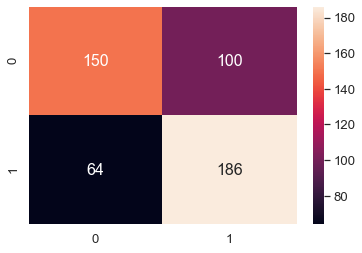

Confidence : 0.1716326530612245 
		Precision:  (0.6514084507042254, 0.74) 	F1 Score: 0.6928838951310863 	Accuracy:  0.672


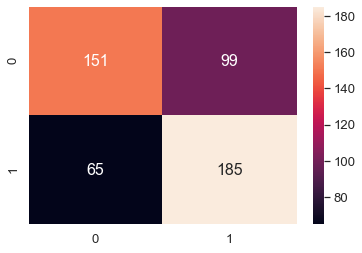

Confidence : 0.19183673469387755 
		Precision:  (0.6548042704626335, 0.736) 	F1 Score: 0.6930320150659134 	Accuracy:  0.674


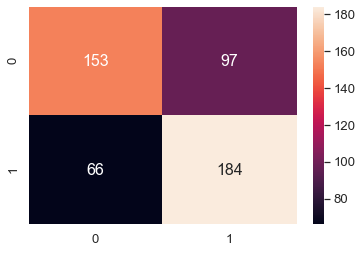

Confidence : 0.2120408163265306 
		Precision:  (0.6570397111913358, 0.728) 	F1 Score: 0.6907020872865275 	Accuracy:  0.674


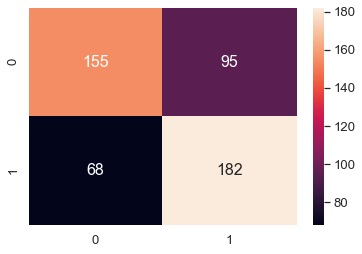

Confidence : 0.23224489795918368 
		Precision:  (0.6605839416058394, 0.724) 	F1 Score: 0.6908396946564885 	Accuracy:  0.676


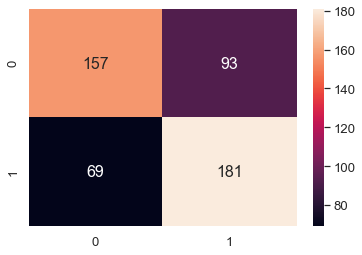

Confidence : 0.2524489795918367 
		Precision:  (0.6703703703703704, 0.724) 	F1 Score: 0.6961538461538462 	Accuracy:  0.684


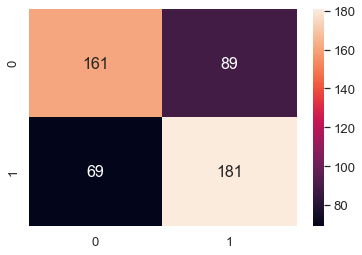

Confidence : 0.2726530612244898 
		Precision:  (0.6716981132075471, 0.712) 	F1 Score: 0.69126213592233 	Accuracy:  0.682


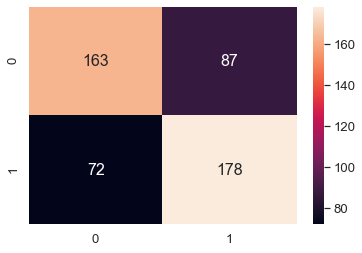

Confidence : 0.29285714285714287 
		Precision:  (0.6768060836501901, 0.712) 	F1 Score: 0.6939571150097466 	Accuracy:  0.686


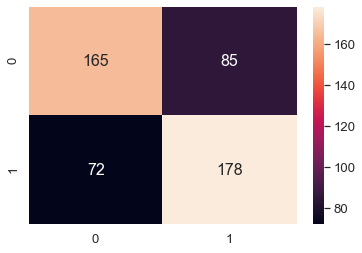

Confidence : 0.3130612244897959 
		Precision:  (0.6768060836501901, 0.712) 	F1 Score: 0.6939571150097466 	Accuracy:  0.686


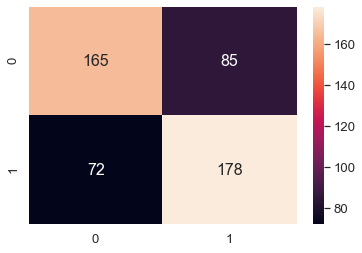

Confidence : 0.333265306122449 
		Precision:  (0.6793893129770993, 0.712) 	F1 Score: 0.6953125000000001 	Accuracy:  0.688


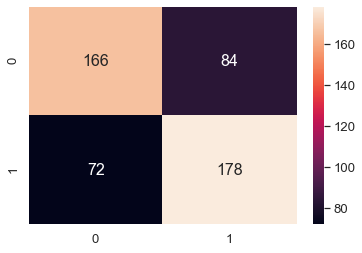

Confidence : 0.35346938775510206 
		Precision:  (0.686046511627907, 0.708) 	F1 Score: 0.6968503937007874 	Accuracy:  0.692


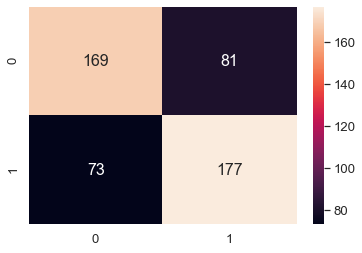

Confidence : 0.3736734693877551 
		Precision:  (0.6848249027237354, 0.704) 	F1 Score: 0.6942800788954635 	Accuracy:  0.69


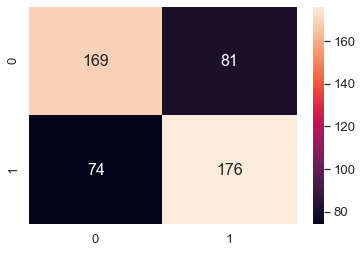

Confidence : 0.39387755102040817 
		Precision:  (0.6848249027237354, 0.704) 	F1 Score: 0.6942800788954635 	Accuracy:  0.69


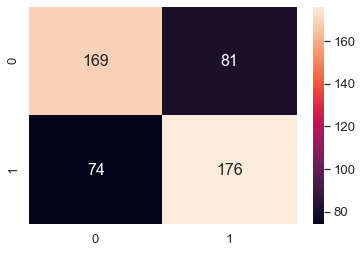

Confidence : 0.4140816326530612 
		Precision:  (0.6889763779527559, 0.7) 	F1 Score: 0.6944444444444445 	Accuracy:  0.692


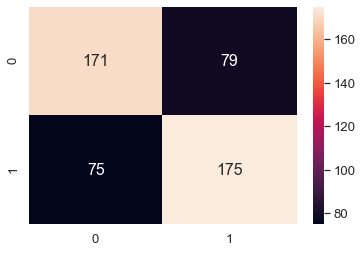

Confidence : 0.4342857142857143 
		Precision:  (0.6889763779527559, 0.7) 	F1 Score: 0.6944444444444445 	Accuracy:  0.692


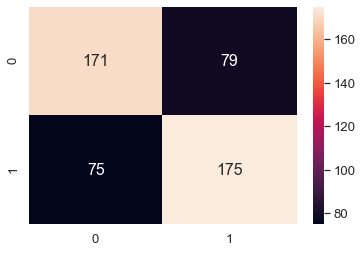

Confidence : 0.45448979591836736 
		Precision:  (0.6877470355731226, 0.696) 	F1 Score: 0.6918489065606361 	Accuracy:  0.69


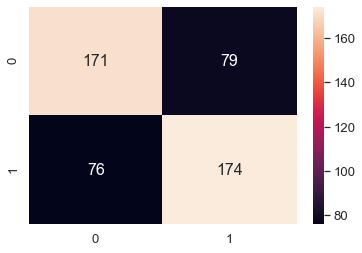

Confidence : 0.4746938775510204 
		Precision:  (0.6877470355731226, 0.696) 	F1 Score: 0.6918489065606361 	Accuracy:  0.69


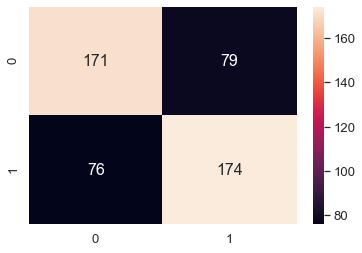

Confidence : 0.49489795918367346 
		Precision:  (0.6877470355731226, 0.696) 	F1 Score: 0.6918489065606361 	Accuracy:  0.69


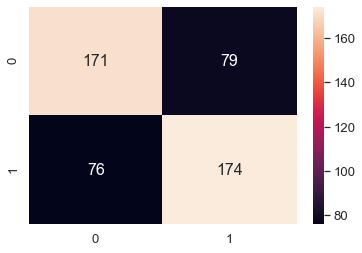

Confidence : 0.5151020408163265 
		Precision:  (0.6896551724137931, 0.64) 	F1 Score: 0.6639004149377593 	Accuracy:  0.676


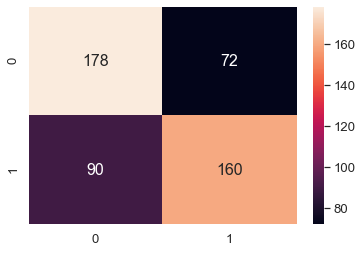

Confidence : 0.5353061224489796 
		Precision:  (0.6962616822429907, 0.596) 	F1 Score: 0.6422413793103448 	Accuracy:  0.668


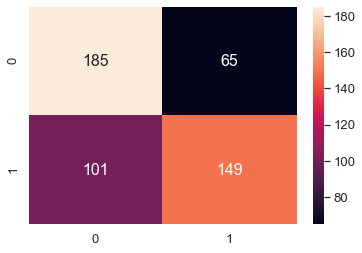

Confidence : 0.5555102040816327 
		Precision:  (0.7024390243902439, 0.576) 	F1 Score: 0.6329670329670329 	Accuracy:  0.666


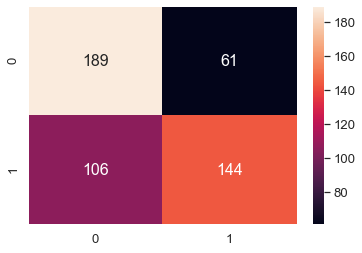

Confidence : 0.5757142857142857 
		Precision:  (0.698019801980198, 0.564) 	F1 Score: 0.6238938053097346 	Accuracy:  0.66


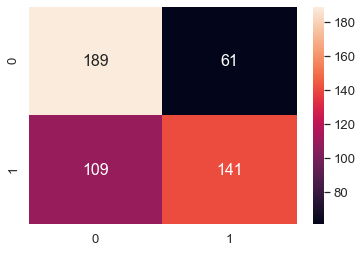

Confidence : 0.5959183673469388 
		Precision:  (0.6954314720812182, 0.548) 	F1 Score: 0.6129753914988815 	Accuracy:  0.654


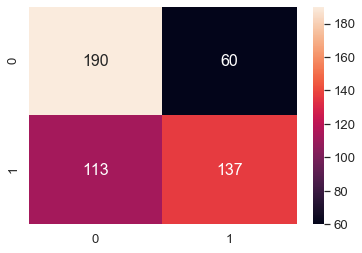

Confidence : 0.6161224489795918 
		Precision:  (0.6875, 0.528) 	F1 Score: 0.5972850678733032 	Accuracy:  0.644


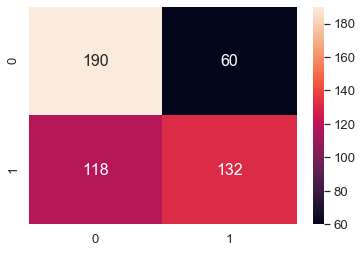

Confidence : 0.6363265306122449 
		Precision:  (0.6844919786096256, 0.512) 	F1 Score: 0.5858123569794049 	Accuracy:  0.638


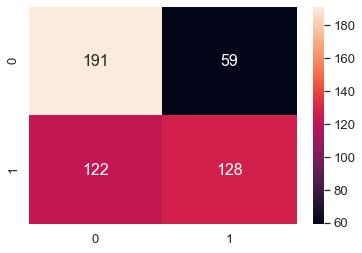

Confidence : 0.656530612244898 
		Precision:  (0.6885245901639344, 0.504) 	F1 Score: 0.5819861431870671 	Accuracy:  0.638


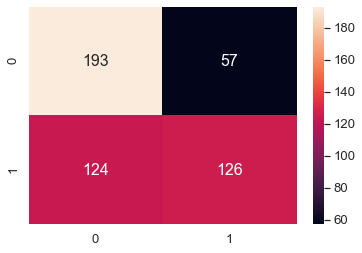

Confidence : 0.676734693877551 
		Precision:  (0.6906077348066298, 0.5) 	F1 Score: 0.580046403712297 	Accuracy:  0.638


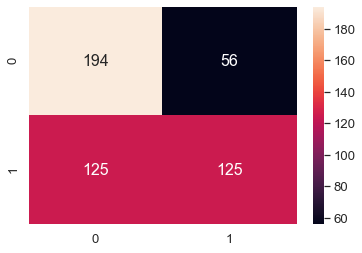

Confidence : 0.6969387755102041 
		Precision:  (0.6971428571428572, 0.488) 	F1 Score: 0.5741176470588235 	Accuracy:  0.638


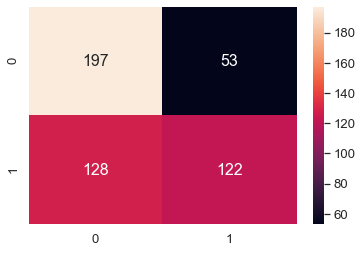

Confidence : 0.7171428571428571 
		Precision:  (0.6976744186046512, 0.48) 	F1 Score: 0.5687203791469195 	Accuracy:  0.636


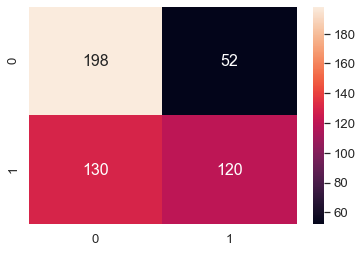

Confidence : 0.7373469387755102 
		Precision:  (0.6941176470588235, 0.472) 	F1 Score: 0.5619047619047619 	Accuracy:  0.632


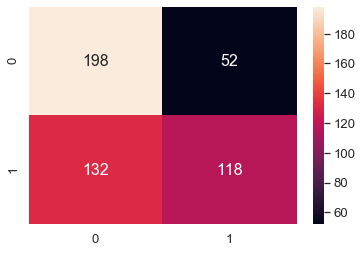

Confidence : 0.7575510204081632 
		Precision:  (0.6964285714285714, 0.468) 	F1 Score: 0.5598086124401914 	Accuracy:  0.632


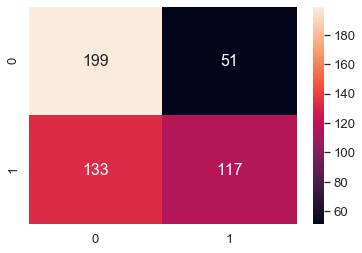

Confidence : 0.7777551020408163 
		Precision:  (0.703030303030303, 0.464) 	F1 Score: 0.5590361445783132 	Accuracy:  0.634


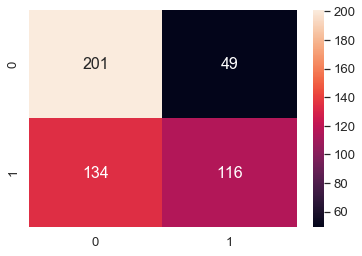

Confidence : 0.7979591836734694 
		Precision:  (0.7125, 0.456) 	F1 Score: 0.5560975609756097 	Accuracy:  0.636


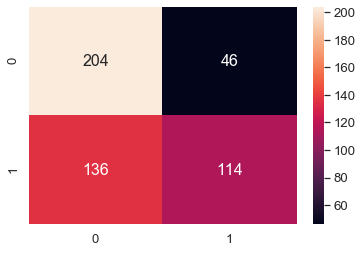

Confidence : 0.8181632653061224 
		Precision:  (0.7151898734177216, 0.452) 	F1 Score: 0.553921568627451 	Accuracy:  0.636


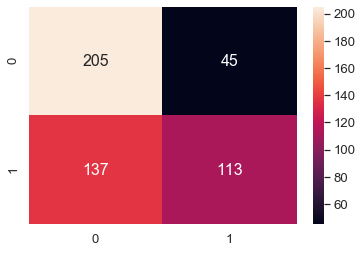

Confidence : 0.8383673469387755 
		Precision:  (0.7254901960784313, 0.444) 	F1 Score: 0.5508684863523573 	Accuracy:  0.638


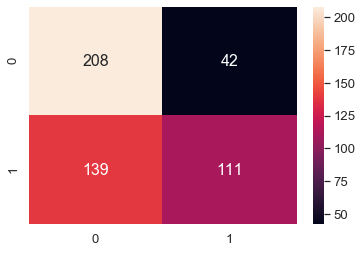

Confidence : 0.8585714285714285 
		Precision:  (0.726027397260274, 0.424) 	F1 Score: 0.5353535353535354 	Accuracy:  0.632


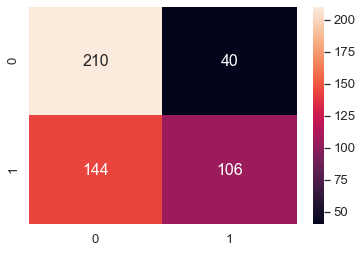

Confidence : 0.8787755102040816 
		Precision:  (0.7266187050359713, 0.404) 	F1 Score: 0.519280205655527 	Accuracy:  0.626


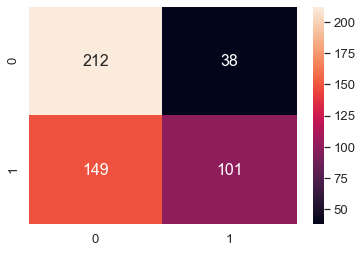

Confidence : 0.8989795918367347 
		Precision:  (0.7266187050359713, 0.404) 	F1 Score: 0.519280205655527 	Accuracy:  0.626


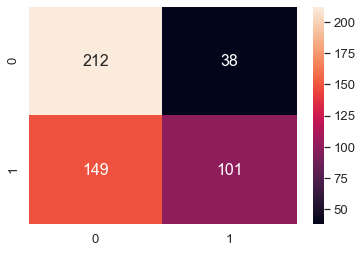

Confidence : 0.9191836734693878 
		Precision:  (0.7238805970149254, 0.388) 	F1 Score: 0.5052083333333334 	Accuracy:  0.62


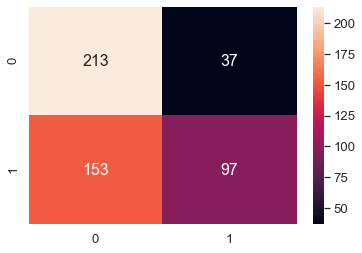

Confidence : 0.9393877551020408 
		Precision:  (0.717741935483871, 0.356) 	F1 Score: 0.4759358288770054 	Accuracy:  0.608


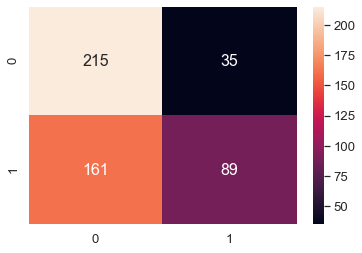

Confidence : 0.9595918367346938 
		Precision:  (0.7288135593220338, 0.344) 	F1 Score: 0.46739130434782605 	Accuracy:  0.608


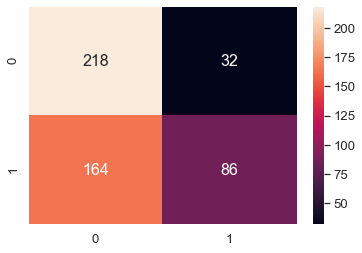

Confidence : 0.9797959183673469 
		Precision:  (0.74, 0.296) 	F1 Score: 0.4228571428571428 	Accuracy:  0.596


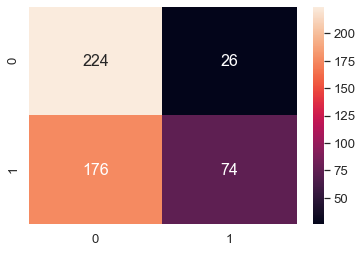

Confidence : 1.0 Precision:  [1, 0]


In [38]:
roc = genROC(devSet, visualbertPreds, 0.01, 50)

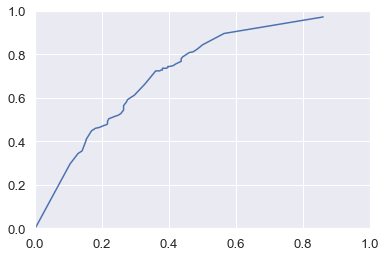

In [29]:
plotPR(roc, False)

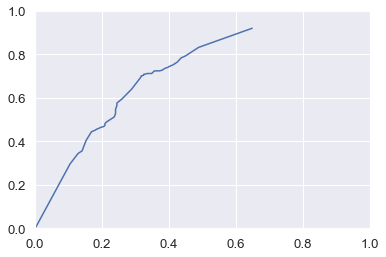

In [39]:
plotPR(roc, False)

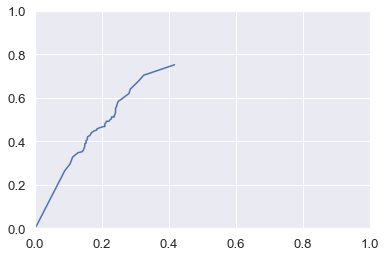

In [278]:
plotPR(roc, False)

# Some Jugad time -->

In [33]:
# Probability Recalibration -->
def clamp(i, imin, imax, omin, omax):
    aa = omin + (((omax - omin) / (imax - imin)) * (i - imin))  # The formula to map ranges
    return aa


def valMapMids(i, imin, imax, mid, omin, omax):
    aa = 0.0
    if(i <= mid):
        aa = ((i - imin) * (((omax-omin)/2.0)/(mid - imin))) + omin
    else:
        aa = ((i - mid) * (((omax-omin)/2.0)/(imax - mid))) + ((omax-omin)/2)
    return aa


def calibrate(probs, thres=0.04):
    for i in range(0, len(probs)):
        if probs[i] <= thres:
            probs[i] *= (1/thres)
        else:
            probs[i] = clamp(probs[i], thres, 1, 0.5, 1)
#             print(probs[i])
    return probs

In [34]:
roc_auc_score(devSet['label'], visualbertPreds['proba'])

0.7341599999999999

In [36]:
visualbertPreds['proba'] = [valMapMids(i, 0, 1, 0.04, 0, 1) for i in visualbertPreds['proba']]
roc_auc_score(devSet['label'], visualbertPreds['proba'])

0.7341599999999999

In [257]:
visualbertPreds[['id', 'proba', 'label']].to_csv('submission.csv')

In [26]:
probs = calibrate(visualbertPreds['proba'])
roc_auc_score(devSet['label'], probs)

<ipython-input-23-86fd9b8942e8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probs[i] = clamp(probs[i], thres, 1, 0.5, 1)
<ipython-input-23-86fd9b8942e8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probs[i] *= (1/thres)


0.7297919999999999

In [254]:
visualbertPreds.head()

,id,proba,label
0,16395,0.971562,1
1,37405,0.998674,1
2,94180,0.718230,0
3,54321,0.450920,0
4,97015,0.999065,1


In [255]:
res

0      0.963483
1      0.873552
2      0.876677
3      0.972894
4      0.997570
         ...   
495    0.674472
496    0.627534
497    0.834494
498    0.659044
499    0.714251
Name: proba, Length: 500, dtype: float64

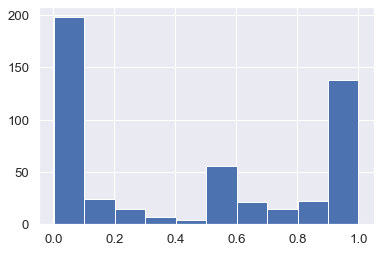

In [37]:
visualbertPreds['proba'].hist()

In [110]:
merged = pd.merge(visualbertPreds[['id', 'proba']], devSet, on='id')

In [89]:
devSet.head()

,id,img,label,text
0,8291,mmfCache/data/datasets/hateful_memes/defaults/...,1,white people is this a shooting range
1,46971,mmfCache/data/datasets/hateful_memes/defaults/...,1,bravery at its finest
2,3745,mmfCache/data/datasets/hateful_memes/defaults/...,1,your order comes to $37.50 and your white priv...
3,83745,mmfCache/data/datasets/hateful_memes/defaults/...,1,it is time.. to send these parasites back to t...
4,80243,mmfCache/data/datasets/hateful_memes/defaults/...,1,mississippi wind chime


In [111]:
merged.head()

,id,proba,img,label,text
0,8291,0.741540,mmfCache/data/datasets/hateful_memes/defaults/...,1,white people is this a shooting range
1,46971,0.105018,mmfCache/data/datasets/hateful_memes/defaults/...,1,bravery at its finest
2,3745,0.001221,mmfCache/data/datasets/hateful_memes/defaults/...,1,your order comes to $37.50 and your white priv...
3,83745,0.808150,mmfCache/data/datasets/hateful_memes/defaults/...,1,it is time.. to send these parasites back to t...
4,80243,0.982800,mmfCache/data/datasets/hateful_memes/defaults/...,1,mississippi wind chime


In [113]:
len(merged)

500

In [112]:
def getDuplicates(merged):
    duplicates = []
    for i, row in merged.iterrows():
        val = merged[row['text'] == merged['text']]
        if len(val) > 1:
            duplicates.append(row)
    return pd.DataFrame(duplicates)

In [119]:
duplicates = getDuplicates(merged)
print("Number of duplicates", len(duplicates))
print((len(duplicates) / len(merged))*100)

Number of duplicates 161
32.2


In [78]:
duplicates = getDuplicates(trainSet)
print("Number of duplicates", len(duplicates))
print((len(duplicates) / len(trainSet))*100)

Number of duplicates 2466
29.011764705882353


In [120]:
sortedDups = duplicates.sort_values('text')

In [121]:
sortedDups

,id,proba,img,label,text
83,48370,0.998374,mmfCache/data/datasets/hateful_memes/defaults/...,1,72 virgins are ready to get fucked up
107,82509,0.549490,mmfCache/data/datasets/hateful_memes/defaults/...,0,72 virgins are ready to get fucked up
480,41296,0.005967,mmfCache/data/datasets/hateful_memes/defaults/...,0,94% of them test positive for rh blood type wh...
324,56241,0.866297,mmfCache/data/datasets/hateful_memes/defaults/...,1,94% of them test positive for rh blood type wh...
388,2783,0.002779,mmfCache/data/datasets/hateful_memes/defaults/...,1,a picture of my great great great grand grandf...
...,...,...,...,...,...
294,7382,0.005585,mmfCache/data/datasets/hateful_memes/defaults/...,1,wouldn't be the last time those people used th...
411,4621,0.112968,mmfCache/data/datasets/hateful_memes/defaults/...,0,you are what you eat meanwhile in africa
337,10285,0.955203,mmfCache/data/datasets/hateful_memes/defaults/...,1,you are what you eat meanwhile in africa
320,30148,0.712386,mmfCache/data/datasets/hateful_memes/defaults/...,1,you mean i don't have to pick it?!?


In [122]:
len(duplicates)

161

In [123]:
visualbertPreds.head()

,id,proba,label
0,8291,0.741540,1
1,46971,0.105018,0
2,3745,0.001221,0
3,83745,0.808150,1
4,80243,0.982800,1


In [124]:
dupSet = sortedDups[['id', 'img', 'label', 'text']]

In [125]:
dupPred = sortedDups[['id', 'proba', 'label']]

Precision:  (0.6349206349206349, 0.5) 	F1 Score: 0.5594405594405595 	Accuracy:  0.6086956521739131


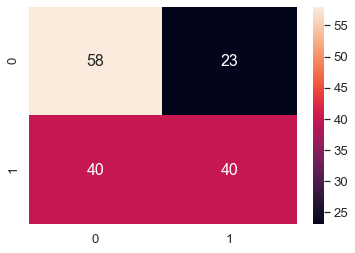

In [126]:
results = evaluate(dupSet, dupPred, 0.5)
print("Precision: ", results['pr'], "\tF1 Score:" , results['f1'], "\tAccuracy: ", results['accuracy'])
plotConfusion(results['confusion'])
truePos, falsePos, trueNegs, falseNegs = results['raw']

Precision:  (0.625, 0.6875) 	F1 Score: 0.6547619047619048 	Accuracy:  0.639751552795031


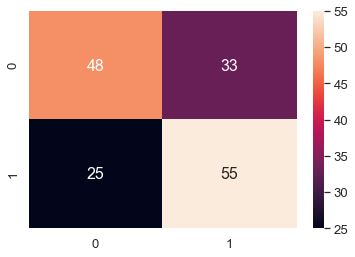

In [129]:
results = evaluate(dupSet, dupPred, 0.04)
print("Precision: ", results['pr'], "\tF1 Score:" , results['f1'], "\tAccuracy: ", results['accuracy'])
plotConfusion(results['confusion'])
truePos, falsePos, trueNegs, falseNegs = results['raw']